In [1]:
from PIL import Image
import random, os, sys, glob, tqdm
import numpy as np
from PIL import ImageOps
from PIL import ImageDraw
from PIL import ImageChops
import math

def draw_circ(draw, x, y, r, color=(255,0,0)):
    draw.ellipse((x-r,y-r,x+r,y+r), fill=color, outline=None)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)


def rotate(origin, point, angle):
    angle = math.radians(angle)
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def is_greyscale(im):
    """
    Check if image is monochrome (1 channel or 3 identical channels)
    """
    if im.mode not in ("L", "RGB"):
        raise ValueError("Unsuported image mode")

    if im.mode == "RGB":
        rgb = im.split()
        if ImageChops.difference(rgb[0],rgb[1]).getextrema()[1] > 30:
            return False
        if ImageChops.difference(rgb[0],rgb[2]).getextrema()[1] > 30:
            return False
    return True

def get_filename(path, img_name):
    img_prefix = img_name.split('.')[0]
    return glob.glob(os.path.join(path, img_prefix+'*'))

def get_anno(anno_paths):
    anno_list = []
    for anno_path in anno_paths:
        with open(anno_path) as anno_file:
            a_anno = [i.strip().split(' ') for i in anno_file]
            for i in a_anno:
                i[1] = float(i[1])
                i[2] = float(i[2])
            if a_anno[0][1] > 0:
                anno_list.append(a_anno)
    return anno_list

def align_eye(im, anno):##mark眼睛resize
    p1 = np.array((anno['right_eye']['x'] + anno['right_eye']['width'] / 2, anno['right_eye']['y'] + anno['right_eye']['height'] / 2)).astype('f')
    p2 = np.array((anno['left_eye']['x'] + anno['right_eye']['width'] / 2, anno['left_eye']['y'] + anno['right_eye']['height'] / 2)).astype('f')
    face_width = anno['face']['width']
    angle = angle_between_2_points(p1, p2)
    print(p1, p2, angle)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    
    dis_width = np.sqrt((x2 - x1)**2 + (y2 - y1)**2) / 2.0
    pad_type = 'edge'
    pad_size = max(im.size[0], im.size[1]) / 2
    np_im = np.array(im)
    tmp_im = Image.fromarray(np.rot90(np.array([np.pad(np_im[:,:,0], pad_size, pad_type), \
                                      np.pad(np_im[:,:,1], pad_size, pad_type), \
                                      np.pad(np_im[:,:,2], pad_size, pad_type)]).T, 3))
    tmp_im = ImageOps.mirror(tmp_im)
    xc = xc + pad_size
    yc = yc + pad_size
    tmp_im = tmp_im.resize((tmp_im.size[0]*2, tmp_im.size[1]*2), Image.LANCZOS)
    tmp_im = tmp_im.rotate(angle, center=(xc*2, yc*2), resample=Image.BICUBIC)
    tmp_im = tmp_im.resize((tmp_im.size[0]/2, tmp_im.size[1]/2), Image.LANCZOS)
    draw = ImageDraw.Draw(tmp_im)
    x1_p = xc - dis_width
    x2_p = xc + dis_width
    print(x1_p, x2_p, yc)
    draw_circ(draw, xc, yc, 2, color=(0,0,255))
    draw_circ(draw, np.ceil(x1_p), yc, 2, color=(0,255,255))
    draw_circ(draw, np.ceil(x2_p), yc, 2, color=(255,0,255))
    w =  face_width
    h = w / 89.0 * 218.0
    x1 = anno['face']['x'] - w/2
    y1 = yc - w / 89.0 * 111.0
    x2 = x1 + 2*w
    y2 = y1 + h
    print(x1, y1, x2, y2, w, h)
    draw.rectangle((x1,y1,x2,y2),outline=(255,0,255))
    del draw
    return tmp_im.crop((x1,y1,x2,y2))

def align_eye_pad(im, anno):
    p1 = np.array((anno[1][1], anno[1][2])).astype('f')
    p2 = np.array((anno[0][1], anno[0][2])).astype('f')
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    dis_width = np.sqrt((x2 - x1)**2 + (y2 - y1)**2) / 2.0
    pad_type = 'edge'
    pad_size = int(max(im.size[0], im.size[1]) / 2)
    np_im = np.array(im)
    tmp_im = Image.fromarray(np.rot90(np.array([np.pad(np_im[:,:,0], pad_size, pad_type), \
                                      np.pad(np_im[:,:,1], pad_size, pad_type), \
                                      np.pad(np_im[:,:,2], pad_size, pad_type)]).T, 3))
    tmp_im = ImageOps.mirror(tmp_im)
    xc = xc + pad_size
    yc = yc + pad_size
    
    for i in anno:
        x = i[1] + pad_size
        y = i[2] + pad_size
    x1 = float(anno[5][1])+ pad_size
    y1 = float(anno[5][2])+ pad_size
    x2 = float(anno[6][1])+ pad_size
    y2 = float(anno[6][2])+ pad_size
    k = (float(anno[0][2]) - float(anno[1][2])) / (float(anno[0][1]) - float(anno[1][1]))
    if k == 0:
        x3 = float(anno[6][1])+ pad_size
        y3 = float(anno[5][2])+ pad_size
        x4 = float(anno[5][1])+ pad_size
        y4 = float(anno[6][2])+ pad_sizeF
    else:
        x3 = ((y2-y1) + k*x1 + x2/k) / (k + 1/k)
        y3 = k*(x3 - x1) + y1
        x4 = ((y1-y2) + k*x2 + x1/k) / (k + 1/k)
        y4 = k*(x4 - x2) + y2
    face_width = distance((x1,y1),(x3,y3))
    face_height = distance((x2,y2),(x3,y3))

    tmp_im = tmp_im.rotate(angle, center=(xc, yc), resample=Image.BICUBIC)

    x1, y1 = rotate((xc, yc),(x1,y1),-angle)
    x2, y2 = rotate((xc, yc),(x2,y2),-angle)
    adj = 2
    w = face_width
    h = face_height #w * adj
    x1 -= w * 3/4
    x2 += w * 3/4
    y1 -= w * 1/3
    y2 += w * 1/3
    return tmp_im.crop((x1,y1,x2,y2))#.resize((,218))


In [41]:
# Set to correspondent path
anno_root = '/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test_annotations'
img_name_list = glob.glob('/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/*')
img_list = []
print img_name_list

['/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/yande.re 462336 sample korie_riko possible_duplicate tagme.jpg', '/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/Konachan - 209438 ayase_sayuki book bow braids cube group headband hirosaki_kanade kantoku long_hair minagawa_yuuhi.png', '/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/yande.re 463496 sample possible_duplicate tagme.jpg']


In [61]:
# Load anno and crop image
def func(im_name):
    anno_name_list = get_filename(anno_root, os.path.basename(im_name))
    im_anno_list = get_anno(anno_name_list)
    for idx, im_anno in enumerate(im_anno_list):
        print im_anno
        pass_im = False
        for i in im_anno:
            if i[1] < 0 or i[2] < 0:
                pass_im = True
        if pass_im:
            continue
        croped_img = align_eye_pad(Image.open(im_name).convert('RGB'), im_anno)
        print croped_img.size
        if croped_img.size[0] < 72 or croped_img.size[1] < 72:
            croped_img.save(os.path.join('./croped_test_small',os.path.basename(im_name).split('.')[0]+'.%d.png'%idx))
        else:
            croped_img.save(os.path.join('./croped_test',os.path.basename(im_name).split('.')[0]+'.%d.png'%idx))

# Test
# func('./新建文件夹/动漫人脸标注2.0/tool/images/000081.jpg')

# Run all images
for i in tqdm.tqdm_notebook(img_name_list):
    print i
    try:
        func(i)
    except:
        pass

# Use multi-thread if you want...
# from multiprocessing.pool import ThreadPool
# p = ThreadPool(6)
# xs = p.map(func, img_name_list)

/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/yande.re 462336 sample korie_riko possible_duplicate tagme.jpg
[['LE', 1108.0, 268.0], ['RE', 1238.0, 216.0], ['NO', 1178.0, 288.0], ['LM', 1178.0, 308.0], ['RM', 1212.0, 294.0], ['TL', 952.0, 40.0], ['BR', 1344.0, 312.0]]
(657, 573)
[['LE', 472.0, 642.0], ['RE', 618.0, 630.0], ['NO', 546.0, 672.0], ['LM', 540.0, 710.0], ['RM', 558.0, 710.0], ['TL', 390.0, 410.0], ['BR', 678.0, 748.0]]
(648, 533)
/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/Konachan - 209438 ayase_sayuki book bow braids cube group headband hirosaki_kanade kantoku long_hair minagawa_yuuhi.png
[['LE', 3544.0, 696.0], ['RE', 3800.0, 584.0], ['NO', 3580.0, 800.0], ['LM', 3620.0, 872.0], ['RM', 3732.0, 864.0], ['TL', 3256.0, 332.0], ['BR', 4096.0, 880.0]]
(1375, 1205)
[['LE', 2264.0, 1804.0], ['RE', 2428.0, 1792.0], ['NO', 2340.0, 1860.0], ['LM', 2324.0, 1920.0], ['RM', 2364.0, 1920.0], ['TL', 2180.0, 1524.0], ['BR', 2532.0, 1964.0]]
(798, 677)
[

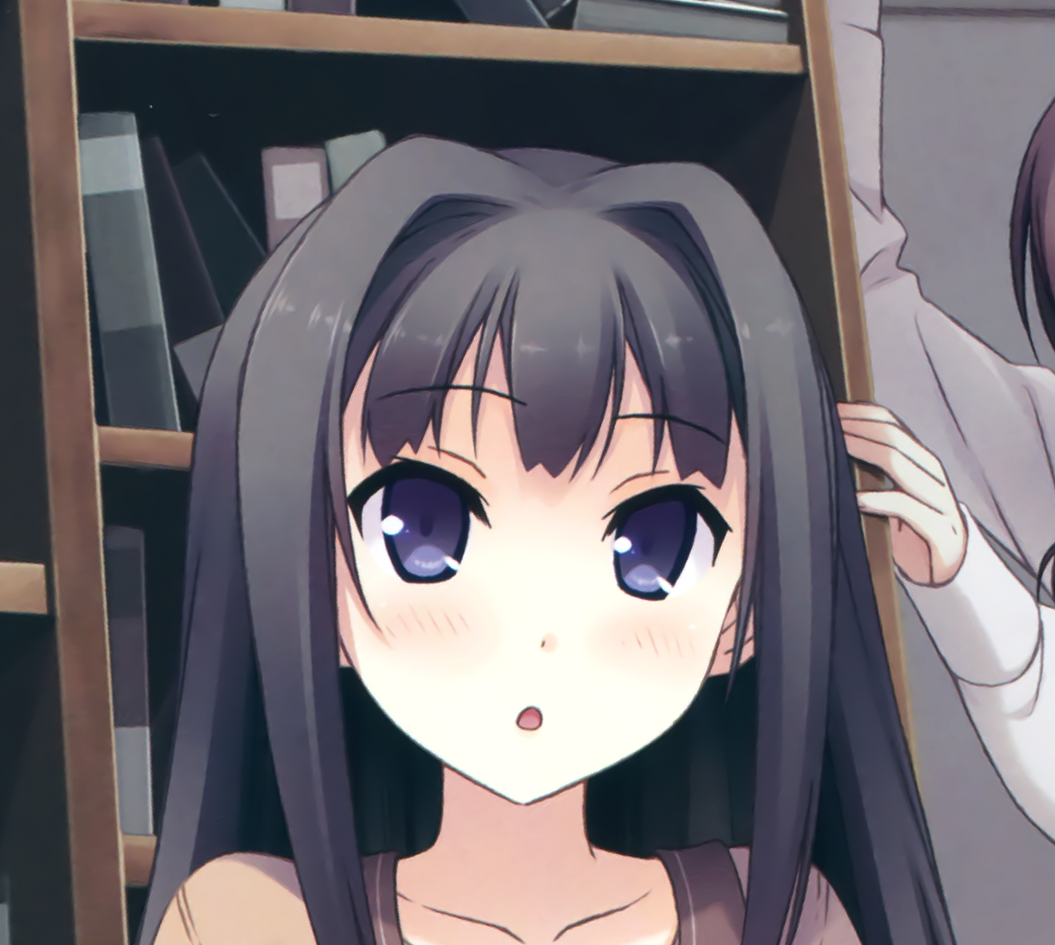

In [59]:
Image.open('/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/croped_test/Konachan - 209438 ayase_sayuki book bow braids cube group headband hirosaki_kanade kantoku long_hair minagawa_yuuhi.3.png')

In [54]:
Image.open('/data2/minjunli/prj/test_anime/img-trans-pytorch/scripts/test/Konachan - 209438 ayase_sayuki book bow braids cube group headband hirosaki_kanade kantoku long_hair minagawa_yuuhi.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
exist_list = [i.split('\\')[-1].split('.')[0] for i in glob.glob('./croped/*')] +  [i.split('\\')[-1].split('.')[0] for i in glob.glob('./croped_small/*')] 
all_list =  [i.split('\\')[-1].split('.')[0] for i in glob.glob('./images//*')] 
failed_img = [i for i in all_list if i not in exist_list]

count = 0
failed = []
null_img = []
for im_name in tqdm.tqdm_notebook(img_name_list):
    anno_name_list = get_filename(anno_root, im_name.split('\\')[-1])
    im_anno_list = get_anno(anno_name_list)
    null_anno = 0
    for idx, im_anno in enumerate(im_anno_list):
        pass_im = False
        for i in im_anno:
            if i[1] < 0 or i[2] < 0:
                pass_im = True
        if pass_im:
            null_anno += 1
    if null_anno == len(im_anno_list):
        count +=1
        null_img.append(im_name.split('\\')[-1].split('.')[0])
#         if not pass_im and im_name.split('\\')[-1].split('.')[0] not in exist_list:
#             func(im_name)

IndexError: list index out of range

In [5]:
mean_img = np.zeros((256,256,3))
for img_path in tqdm.tqdm_notebook(glob.glob('./croped - 副本/*')):
    mean_img += np.array(Image.open(img_path).convert('RGB').resize((256,256))).astype(np.float)
mean_img /= len(glob.glob('./croped - 副本/*'))

/data2/minjunli/tol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


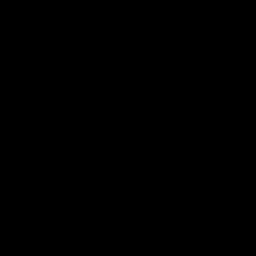

In [6]:
Image.fromarray(mean_img.astype(np.uint8))

In [7]:
mean_img_2 = np.zeros((256,256,3))
for img_path in tqdm.tqdm_notebook(glob.glob('./croped_/*')):
    mean_img_2 += np.array(Image.open(img_path).convert('RGB').resize((256,256))).astype(np.float)
mean_img_2 /= len(glob.glob('./croped/*'))

/data2/minjunli/tol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


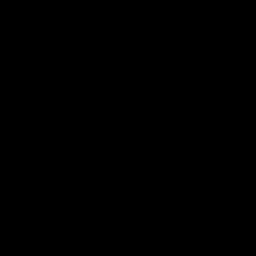

In [8]:
Image.fromarray(mean_img_2.astype(np.uint8))

In [9]:
mean_img_2 = np.zeros((256,256,3))
for img_path in tqdm.tqdm_notebook(glob.glob('./getchu_men_v5/trainA/*')):
    mean_img_2 += np.array(Image.open(img_path).convert('RGB').resize((256,256))).astype(np.float)
mean_img_2 /= len(glob.glob('./getchu_men_v5/trainA/*'))

/data2/minjunli/tol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


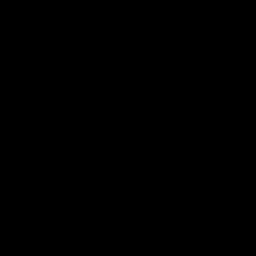

In [10]:
Image.fromarray(mean_img_2.astype(np.uint8))

In [11]:
mean_img_2 = np.zeros((256,256,3))
for img_path in tqdm.tqdm_notebook(glob.glob('./getchu_men_v5/trainB/*')):
    mean_img_2 += np.array(Image.open(img_path).convert('RGB').resize((256,256))).astype(np.float)
mean_img_2 /= len(glob.glob('./getchu_men_v5/trainB/*'))

/data2/minjunli/tol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


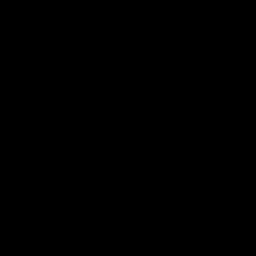

In [12]:
Image.fromarray(mean_img_2.astype(np.uint8))